# Project description

In this project, we aim to characterise the effect of Foxa2 in the determination of endoderm and mesoderm lineages in the mouse embryo.

**In this notebook:** Velocity estimation of the decision populations using `scvelo`.

# Initialisation

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann
import scvelo as scv
import cellrank as cr

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors
from seaborn import heatmap
from matplotlib import gridspec

import os

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.3 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1


In [2]:
scv.__version__

'0.2.1'

In [3]:
cr.logging.print_versions()

cellrank==1.0.0-rc.0 scanpy==1.5.1 anndata==0.7.4 numpy==1.17.3 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 scvelo==0.2.1


In [4]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [5]:
import datetime

today = datetime.date.today().strftime('%y%m%d')

In [6]:
#%matplotlib inline
#%config InlineBackend.figure_format='retina' # mac

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
data_dir = './../data/'

In [7]:
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)


Add my color scheme.

In [8]:
colors2 = pl.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = pl.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Load dataset

We load a batch corrected data set, which has the logCPM-normalized, but non-corrected data matrix as `raw`. This data set has annotated clusters. 

In [9]:
adata = sc.read(filename=data_dir + 'data_annotated_dec20.h5ad')


Load velocity data.

In [10]:
velo_dir = os.listdir('./../data/velocyto/')

In [11]:
batch_names = [direc[7:] for direc in velo_dir]
included_extensions = ['loom']

In [13]:
adatas = []


for sample_id in velo_dir:
    #select loom file (assuming there is only one, we use the first one from the list)
    file_names = [fn for fn in os.listdir(data_dir + 'velocyto/' + sample_id)
              if any(fn.endswith(ext) for ext in included_extensions)]
    adata_tmp = scv.read(filename=data_dir + 'velocyto/' + sample_id + '/' + file_names[0])
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)

adata_velo = ann.AnnData.concatenate(
    *adatas, 
    batch_key = 'batch', 
    batch_categories = batch_names,
).copy()

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
adata_velo

AnnData object with n_obs × n_vars = 9852 × 27998
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [15]:
adata_velo.obs['batch'].value_counts()

fvf_neg_2     2963
fvf_neg_1     1219
fvf_low_2     1182
fvf_low_3     1172
fvf_high_1    1109
fvf_high_3     947
fvf_low_1      848
fvf_high_2     412
Name: batch, dtype: int64

In [16]:
adata.obs['batch'].value_counts()

fvf_neg_2     2957
fvf_neg_1     1216
fvf_low_2     1171
fvf_low_3     1165
fvf_high_1    1098
fvf_high_3     935
fvf_low_1      842
fvf_high_2     410
Name: batch, dtype: int64

In [17]:
adata.obs_names

Index(['AAACCTGAGACTTGAA-1-fvf_neg_2', 'AAACCTGAGATCACGG-1-fvf_neg_2',
       'AAACCTGAGTCGTACT-1-fvf_neg_2', 'AAACCTGAGTGGCACA-1-fvf_neg_2',
       'AAACCTGCAATAGCGG-1-fvf_neg_2', 'AAACCTGCACTATCTT-1-fvf_neg_2',
       'AAACCTGCACTGCCAG-1-fvf_neg_2', 'AAACCTGCACTTCGAA-1-fvf_neg_2',
       'AAACCTGGTTGCCTCT-1-fvf_neg_2', 'AAACCTGTCGAGGTAG-1-fvf_neg_2',
       ...
       'TTTCCTCAGCTGATAA-1-fvf_low_3', 'TTTCCTCCAACACCTA-1-fvf_low_3',
       'TTTGCGCAGCGGCTTC-1-fvf_low_3', 'TTTGCGCGTTTGTGTG-1-fvf_low_3',
       'TTTGCGCTCCAAAGTC-1-fvf_low_3', 'TTTGGTTAGTTTGCGT-1-fvf_low_3',
       'TTTGGTTGTACAGACG-1-fvf_low_3', 'TTTGTCAAGGCAAAGA-1-fvf_low_3',
       'TTTGTCAGTCTAGTGT-1-fvf_low_3', 'TTTGTCATCAGAGCTT-1-fvf_low_3'],
      dtype='object', name='index', length=9794)

Adapt the `obs_names` of `adata_velo` to the ones in `adata`.

In [18]:
adata_velo.obs_names = [obsnames.split(':')[1].replace('x', '') for obsnames in adata_velo.obs_names.values]

Adapt the `obs_names` of `adata` to the ones in `adata_velo` by removing an extra letter (`-1`).

In [19]:
adata.obs_names = [obsnames.replace('-1', '') for obsnames in adata.obs_names.values]

In [20]:
adata.obs_names

Index(['AAACCTGAGACTTGAA-fvf_neg_2', 'AAACCTGAGATCACGG-fvf_neg_2',
       'AAACCTGAGTCGTACT-fvf_neg_2', 'AAACCTGAGTGGCACA-fvf_neg_2',
       'AAACCTGCAATAGCGG-fvf_neg_2', 'AAACCTGCACTATCTT-fvf_neg_2',
       'AAACCTGCACTGCCAG-fvf_neg_2', 'AAACCTGCACTTCGAA-fvf_neg_2',
       'AAACCTGGTTGCCTCT-fvf_neg_2', 'AAACCTGTCGAGGTAG-fvf_neg_2',
       ...
       'TTTCCTCAGCTGATAA-fvf_low_3', 'TTTCCTCCAACACCTA-fvf_low_3',
       'TTTGCGCAGCGGCTTC-fvf_low_3', 'TTTGCGCGTTTGTGTG-fvf_low_3',
       'TTTGCGCTCCAAAGTC-fvf_low_3', 'TTTGGTTAGTTTGCGT-fvf_low_3',
       'TTTGGTTGTACAGACG-fvf_low_3', 'TTTGTCAAGGCAAAGA-fvf_low_3',
       'TTTGTCAGTCTAGTGT-fvf_low_3', 'TTTGTCATCAGAGCTT-fvf_low_3'],
      dtype='object', length=9794)

In [21]:
adata_velo.obs_names

Index(['AACGTTGCAATGCCAT-fvf_neg_2', 'AAACGGGGTGTCTGAT-fvf_neg_2',
       'AAAGATGAGTGTTGAA-fvf_neg_2', 'AACTTTCCAGATGGCA-fvf_neg_2',
       'AACTCCCCATATACGC-fvf_neg_2', 'AACTTTCAGCCAACAG-fvf_neg_2',
       'AACACGTTCTGTACGA-fvf_neg_2', 'AAAGTAGCAACACGCC-fvf_neg_2',
       'AACCATGAGAGCTGGT-fvf_neg_2', 'AAATGCCCACATTTCT-fvf_neg_2',
       ...
       'TTTCCTCAGCTGATAA-fvf_low_3', 'TTAGGACAGTGCGTGA-fvf_low_3',
       'TTTGTCAAGGCAAAGA-fvf_low_3', 'TTCGGTCGTCTAGCGC-fvf_low_3',
       'TTGCCGTGTAAGCACG-fvf_low_3', 'TTGTAGGGTCCGAGTC-fvf_low_3',
       'TTCTACACATCAGTAC-fvf_low_3', 'TTGAACGAGGCTCATT-fvf_low_3',
       'TTATGCTGTCTAACGT-fvf_low_3', 'TTCTCAAAGTTCGCGC-fvf_low_3'],
      dtype='object', length=9852)

Remove extra cells from `adata_velo` by matching the `obs_names` variables of both data sets.

In [22]:
keep_ref = []
keep_query = []

In [23]:
test_ref = np.asarray(adata.obs_names.values)
test_query =  np.asarray(adata_velo.obs_names.values)

In [24]:
np.intersect1d(test_ref, test_query)

array(['AAACCTGAGACTTGAA-fvf_neg_2', 'AAACCTGAGATCACGG-fvf_neg_2',
       'AAACCTGAGTCGTACT-fvf_neg_2', ..., 'TTTGTCATCGAACTGT-fvf_neg_2',
       'TTTGTCATCTGATTCT-fvf_low_2', 'TTTGTCATCTGTCTCG-fvf_low_2'],
      dtype=object)

In [25]:
batch_key = 'batch'

#Compute cell barcodes that are present in both sets
barcodes_both = np.intersect1d(test_ref, test_query)
#reduce both data sets to the intersection of indexes
keep_ref.extend(list(test_ref[np.in1d(test_ref, barcodes_both)]))
keep_query.extend(list(test_query[np.in1d(test_query, barcodes_both)]))

In [26]:
len(keep_query)

9794

In [27]:
len(keep_ref)

9794

Reduce both data sets to the matched indeces.

In [28]:
adata = adata[keep_ref].copy()
adata_velo = adata_velo[keep_query].copy()

In [29]:
adata_velo

AnnData object with n_obs × n_vars = 9794 × 27998
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [30]:
scv.utils.show_proportions(adata_velo)

Abundance of ['spliced', 'unspliced']: [0.87 0.13]


Merge `adata_velo` into `adata` (also to match indeces).

In [31]:
adata = scv.utils.merge(adata, adata_velo)

In [32]:
adata

AnnData object with n_obs × n_vars = 9794 × 3000
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'Foxa2_levels', 'FVF_Foxa2', 'FVF_Foxa2_merge', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'FVF_Foxa2_colors', 'FVF_Foxa2_merge_colors', 'FVF_colors', 'batch_colors', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_colors', 'epiblast_vs_postepi', 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'tissues_merge_colors', 'tissues_primed_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

# Pre-processing

We already use the pre-processed data as reference, which are log-CPM normalised. Further, the dataset is restricted to the top 3000 informative genes. We normalise the spliced/unspliced counts (*i.e.* the pre-processed data won't be touched).

Compute first and second order moments.

In [33]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 867 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


# Velocity and velocyto graph for dynamical model

In [34]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics
    finished (0:51:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:17) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:25) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [35]:
adata.write(data_dir + 'data_annotated_velo_dec20.h5ad')

In [37]:
adata

AnnData object with n_obs × n_vars = 9794 × 2133
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase', 'FVF', 'louvain', 'louvain_R', 'epiblast', 'endoderm', 'primitive_streak', 'extraembryonic_ecto', 'extraembryonic_endo', 'mesoderm', 'tissues', 'tissues_merge', 'endoderm_res', 'epiblast_res', 'tissues_primed', 'Foxa2_levels', 'FVF_Foxa2', 'FVF_Foxa2_merge', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'FVF_Foxa2_colors', 'FVF_Foxa2_merge_colors', 'FVF_colors', 'batch_colors', 'dendrogram_epiblast_res', 'dendrogram_louvain_R', 'dendrogram_tissues_primed', 'endoderm_res_colors', 'epiblast_res_

# Visualise results

In [36]:
scv.settings.set_figure_params('scvelo')  # for beautified visualization

figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_201104_stream_FVF_Fox2.png


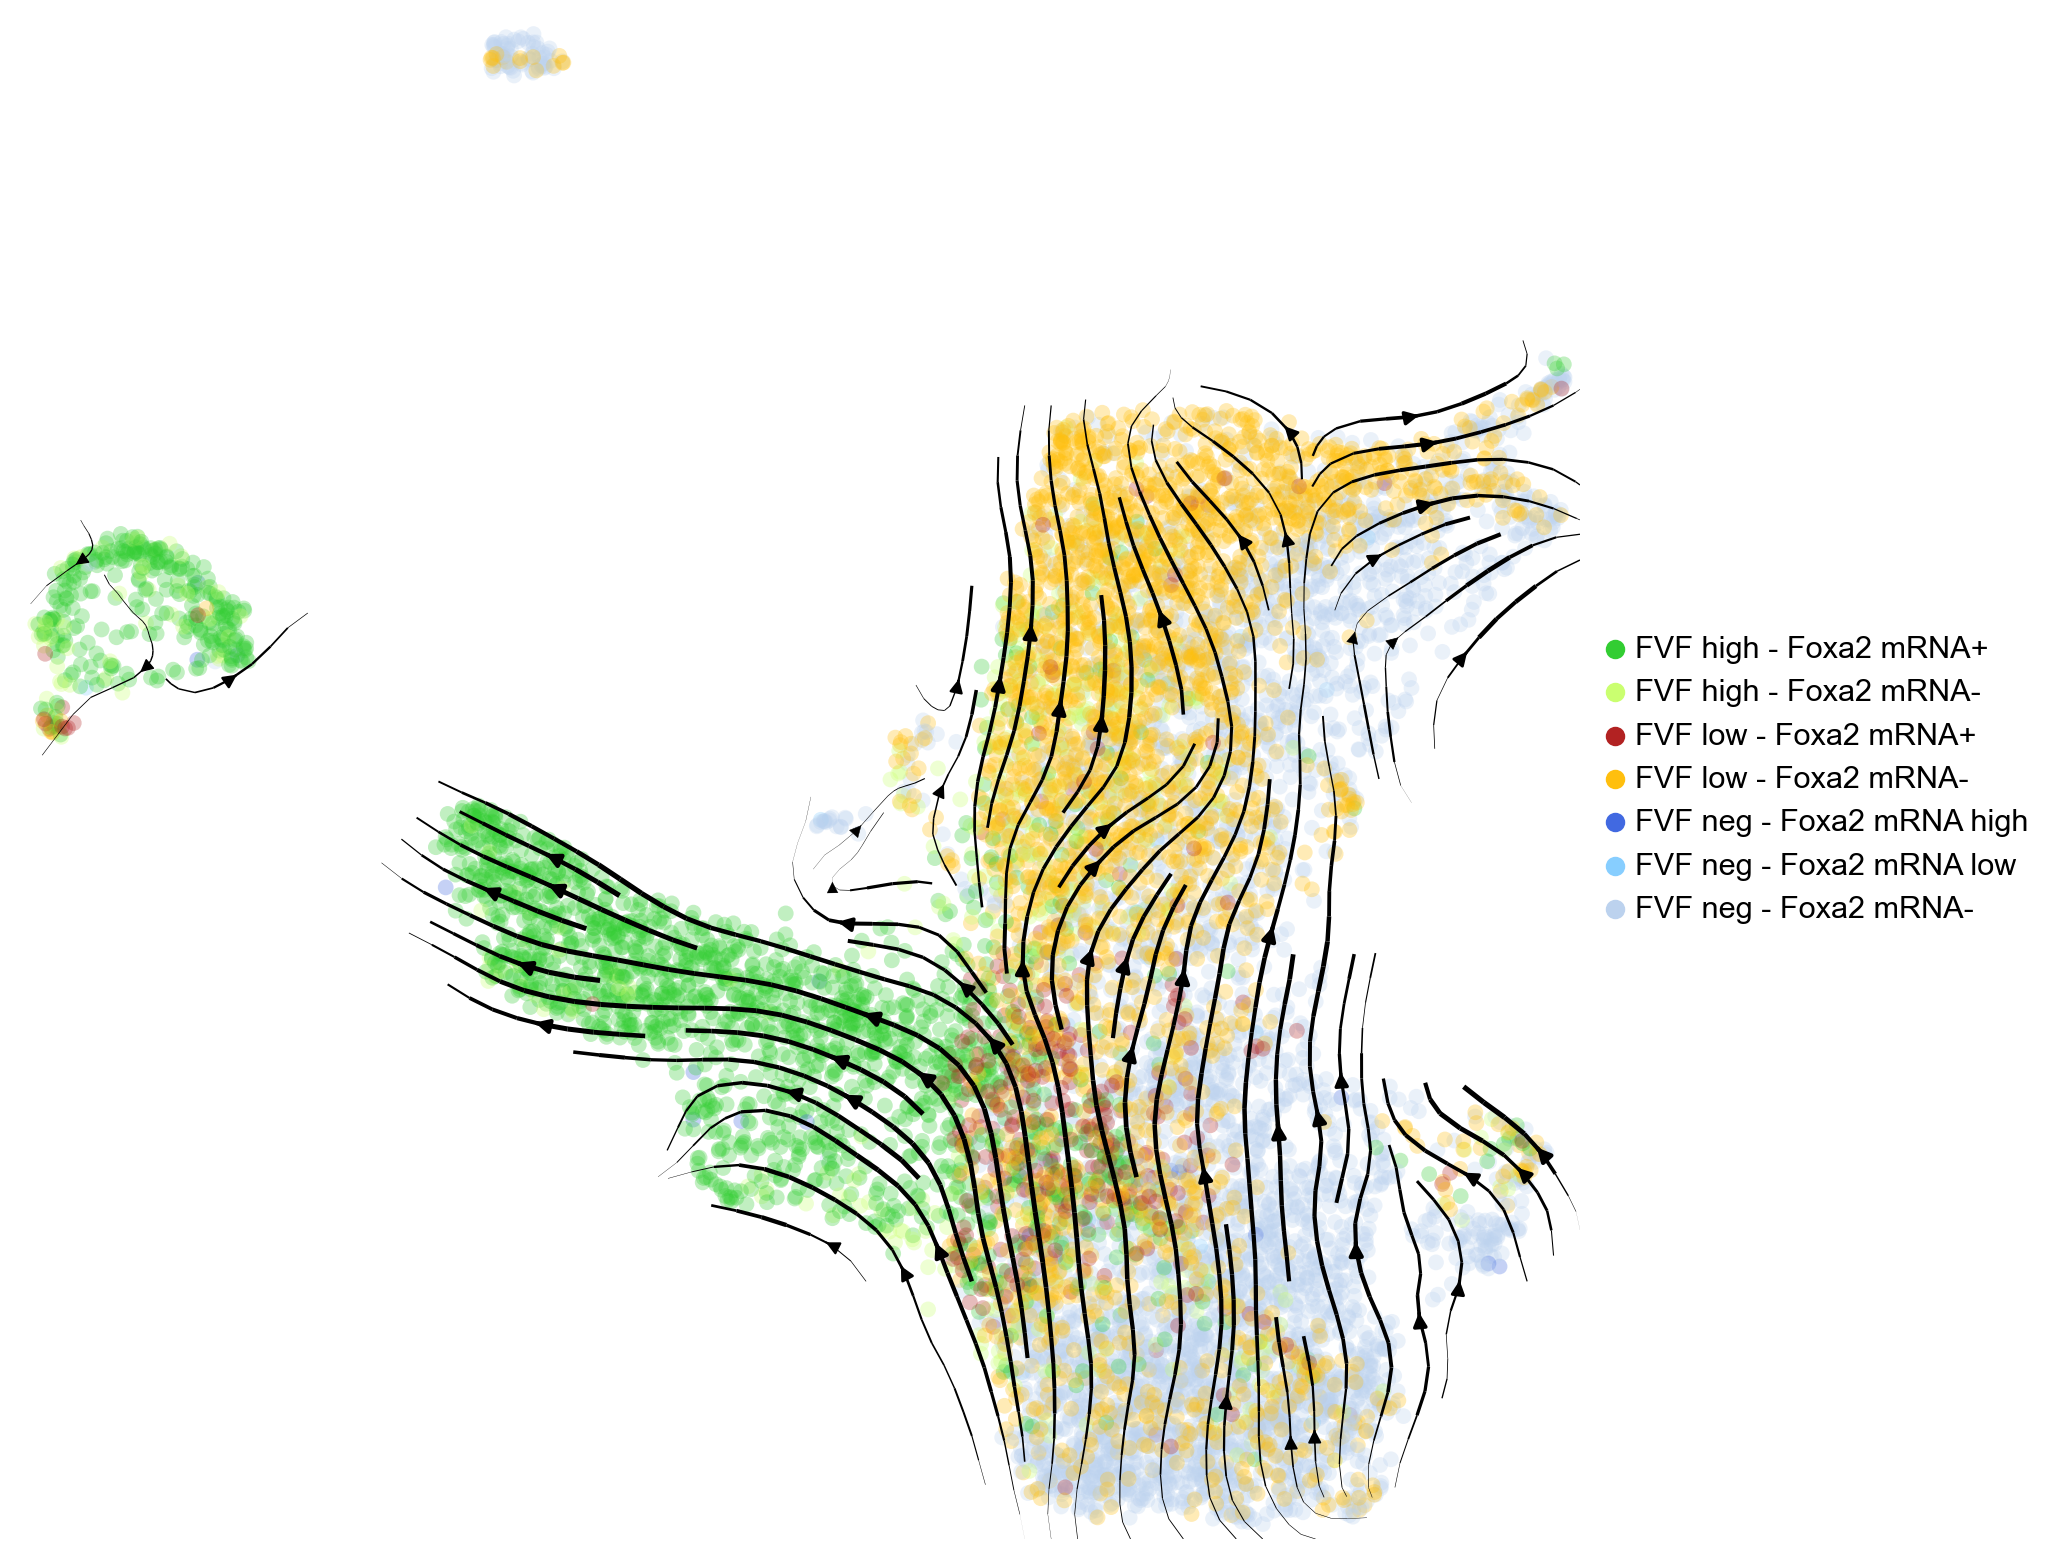

In [40]:
rcParams['figure.figsize']=(10,10)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['FVF_Foxa2_merge'], legend_loc = 'right',
                                 save= today + '_stream_FVF_Fox2.pdf', title='')

saving figure to file ./figures/scvelo_201104_grid_FVF_Fox2.pdf


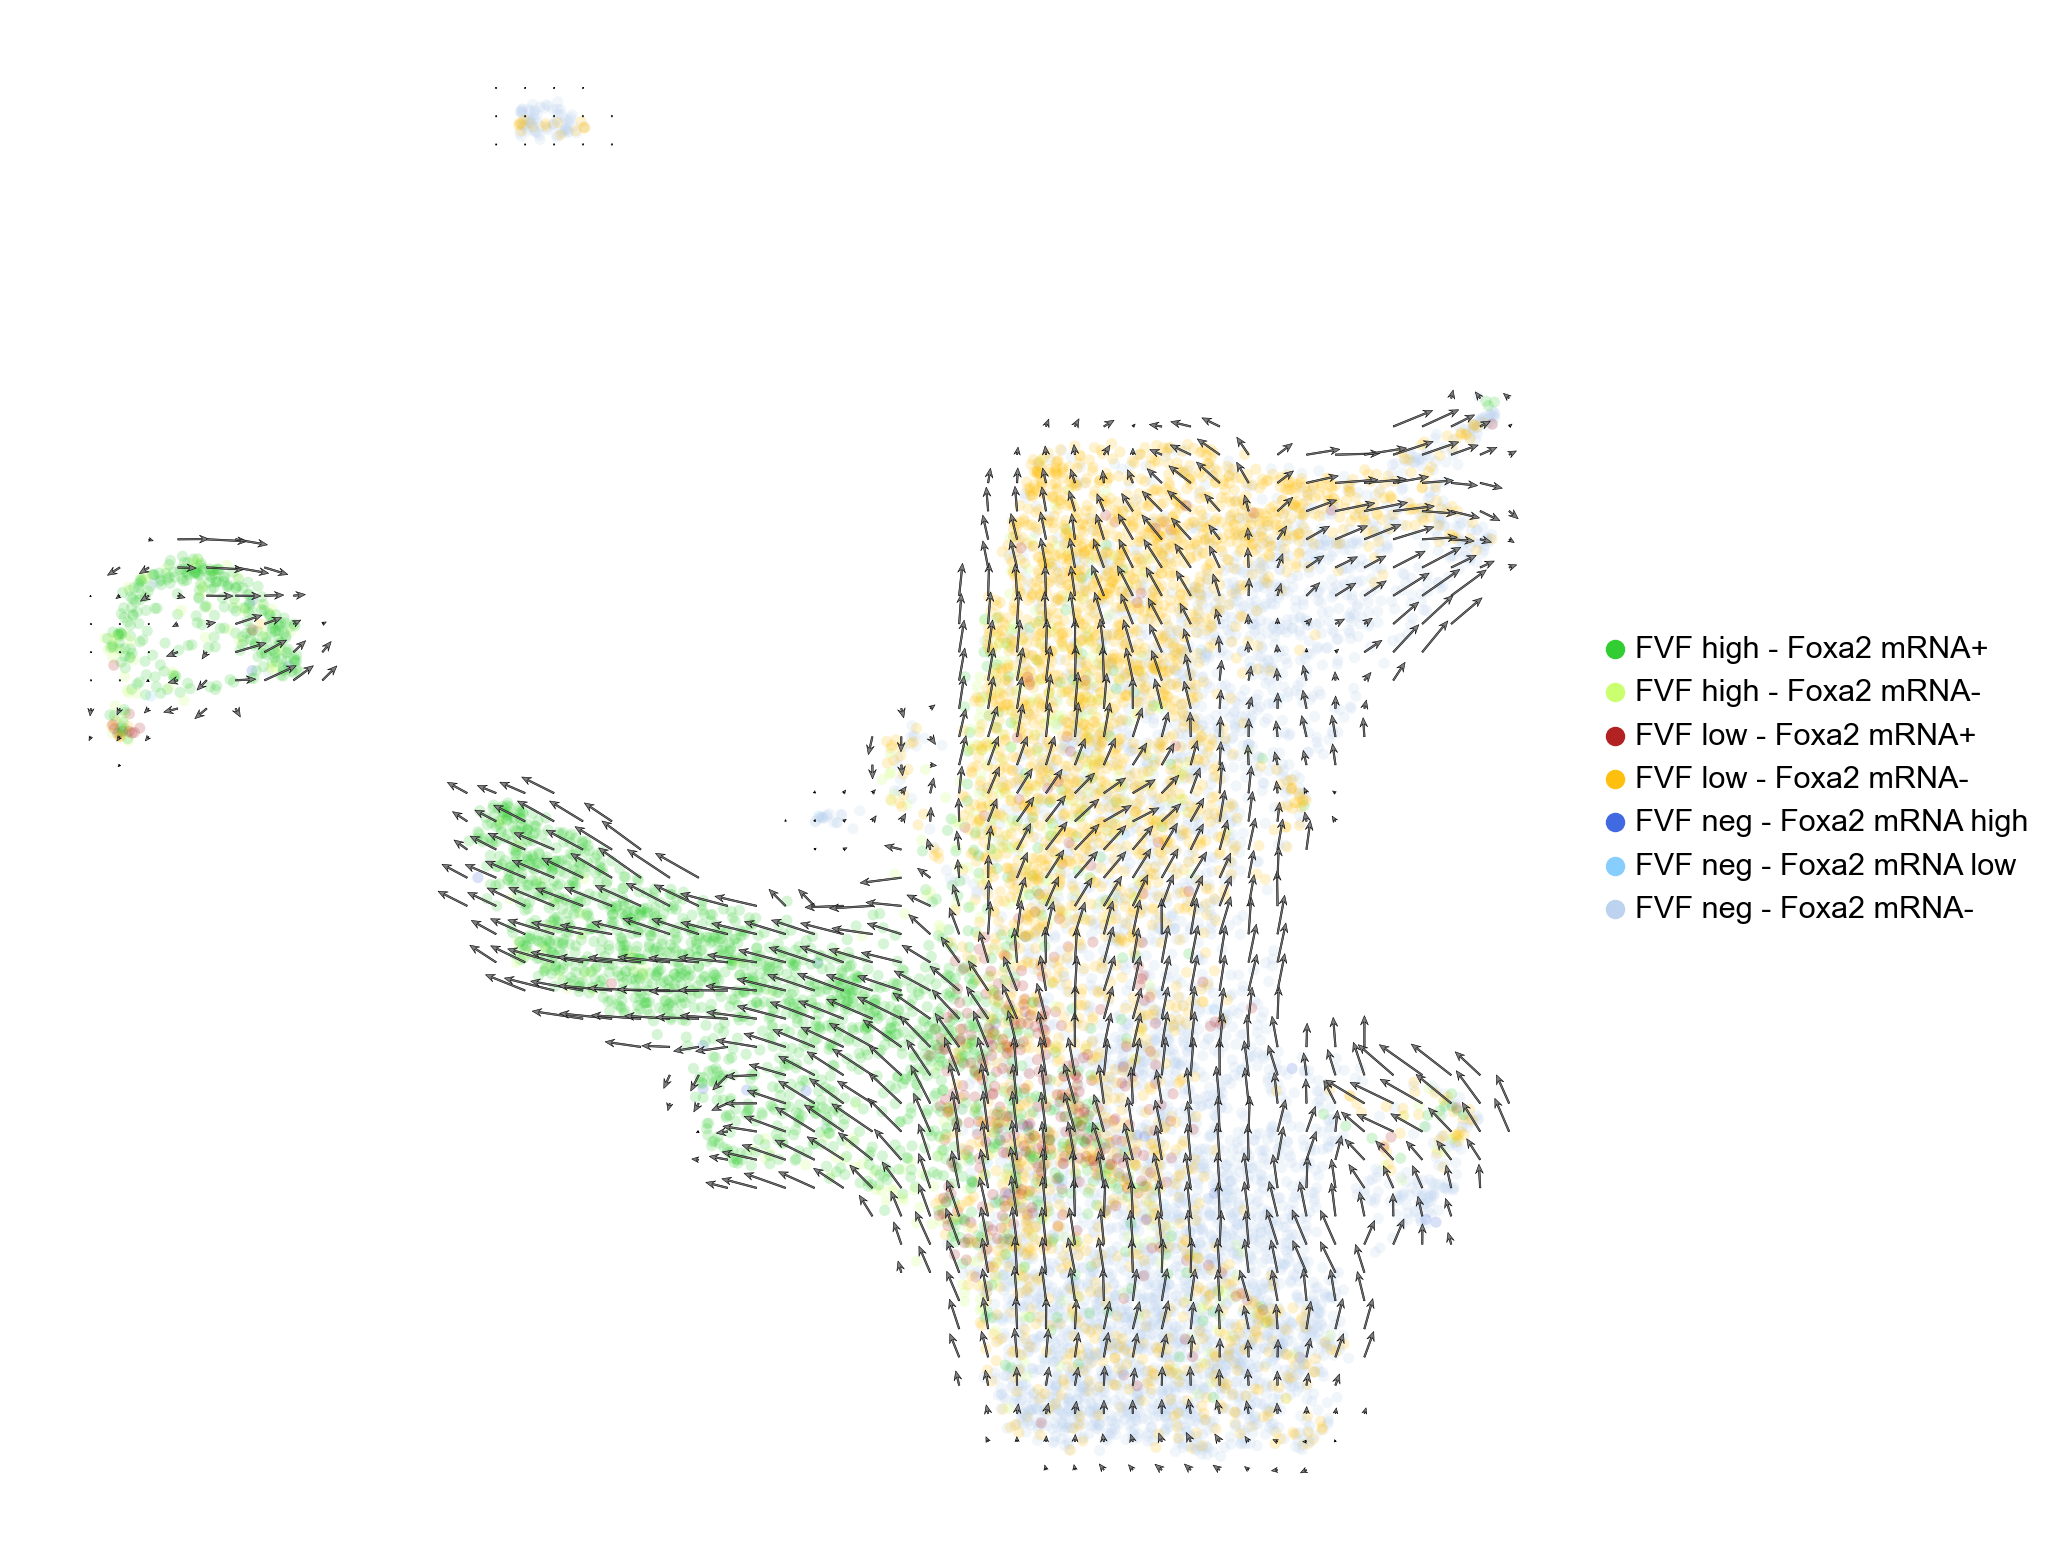

saving figure to file ./figures/scvelo_201104_arrows_FVF_Fox2.pdf


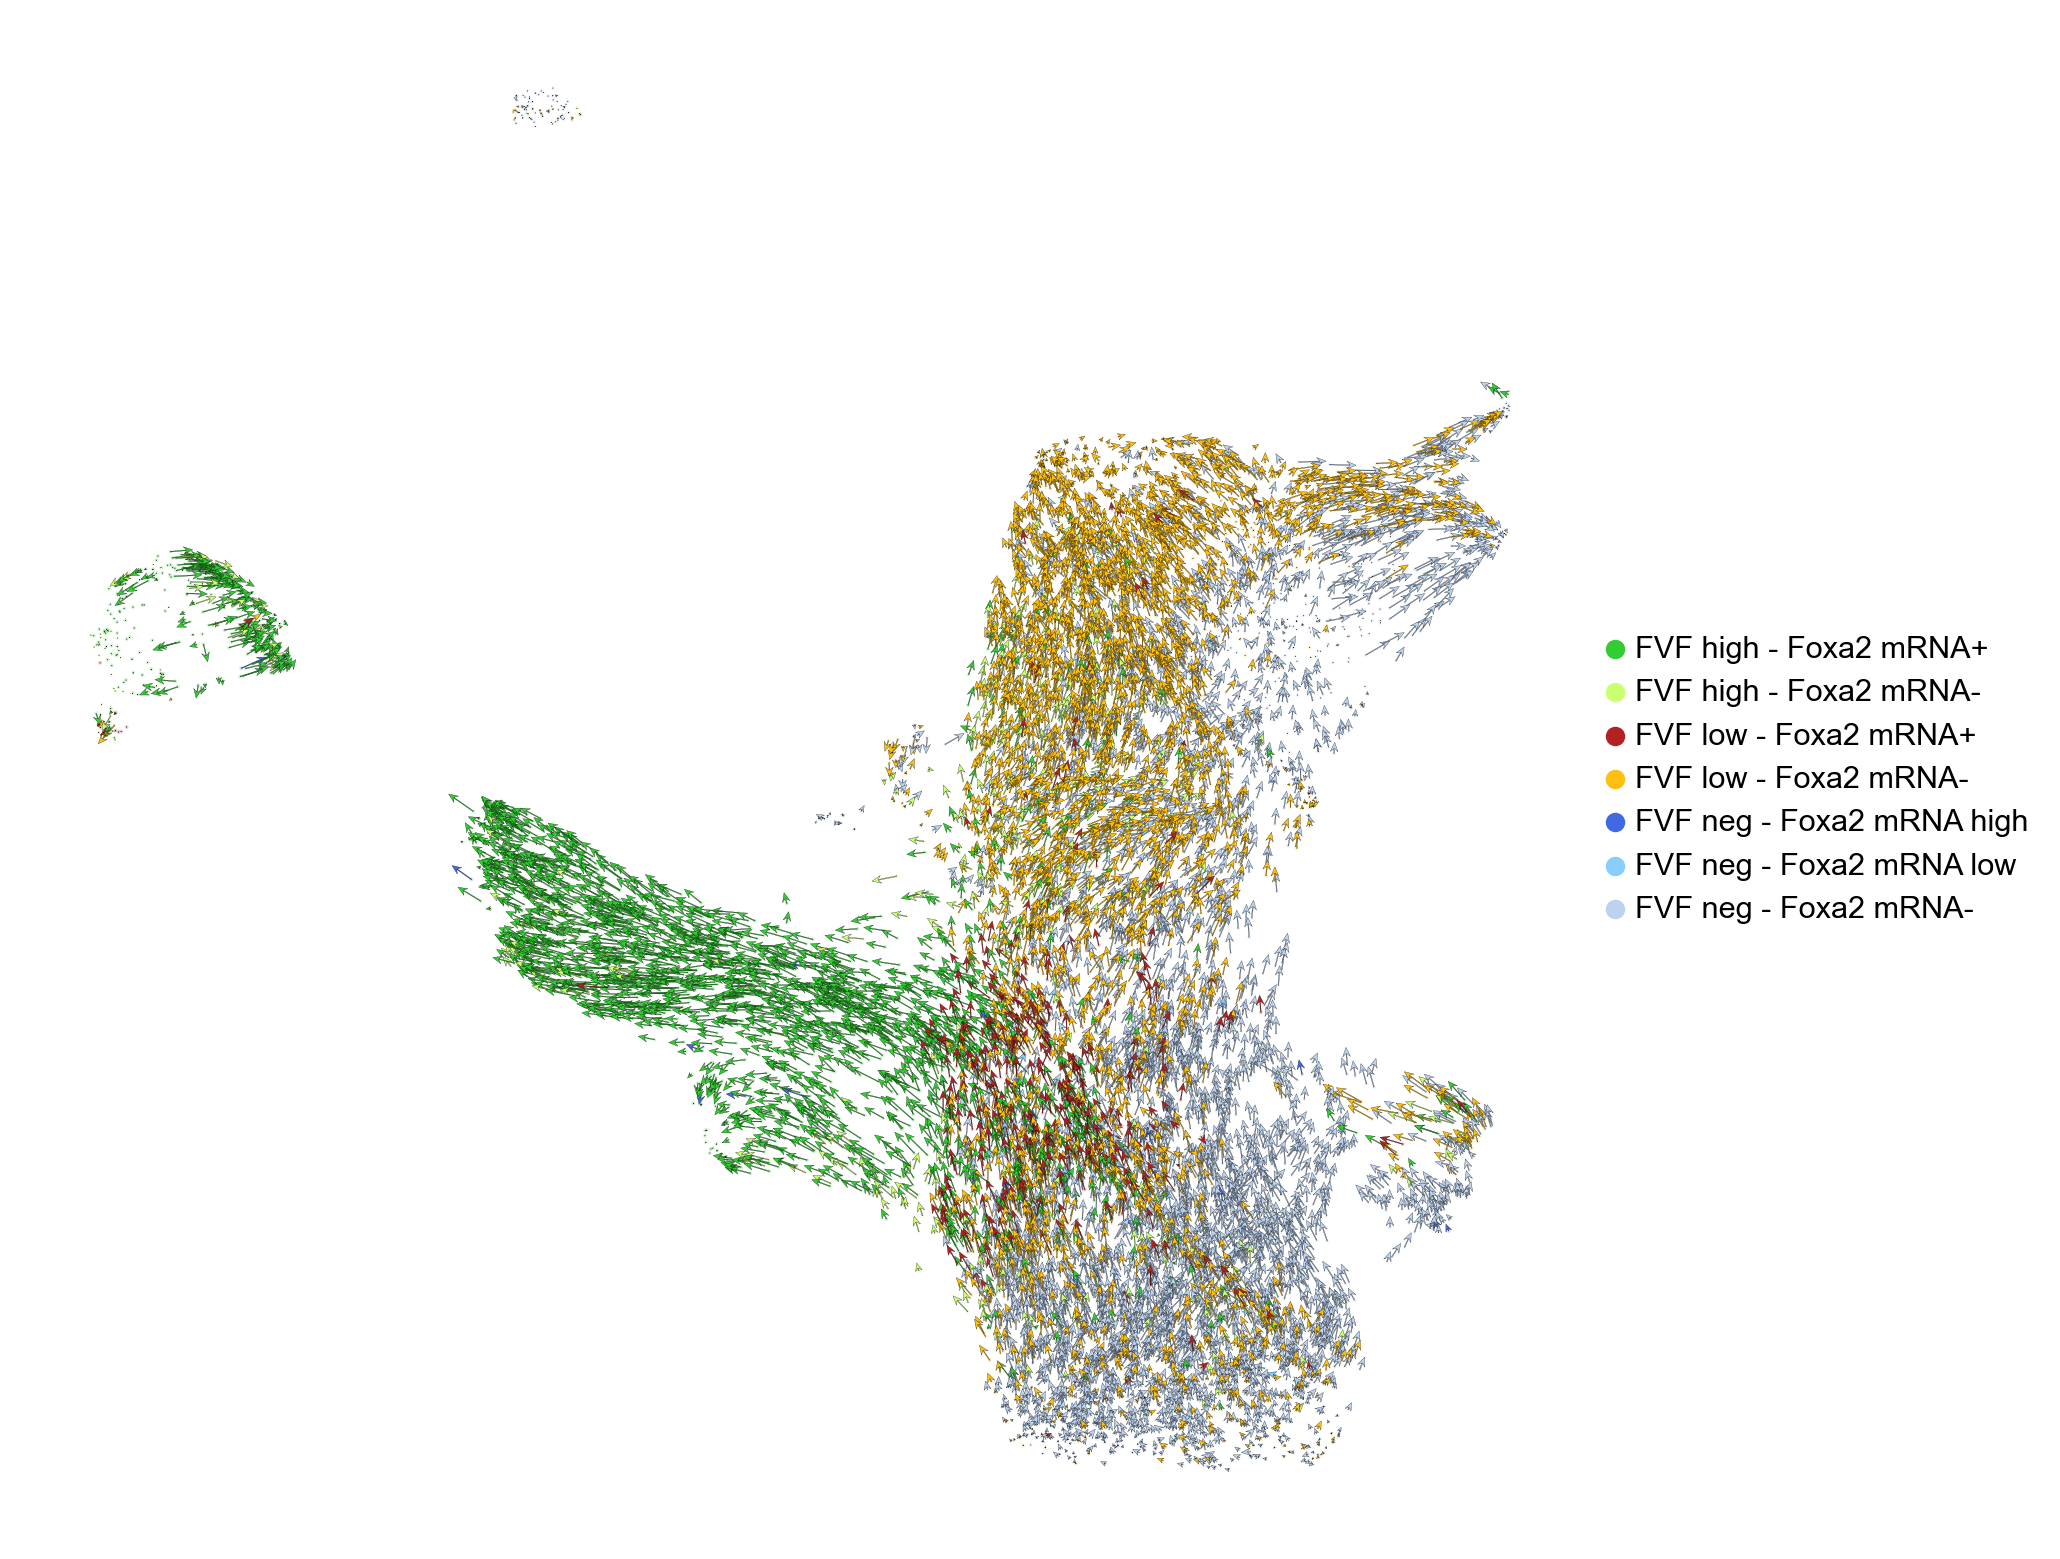

In [41]:
rcParams['figure.figsize']=(10,10)
scv.pl.velocity_embedding_grid(adata, basis='umap', color=['FVF_Foxa2_merge'], arrow_length=5,
                                 legend_loc = 'right',
                                 save= today + '_grid_FVF_Fox2.pdf', title='')
scv.pl.velocity_embedding(adata, basis='umap', color=['FVF_Foxa2_merge'], arrow_length=10,
                                 legend_loc = 'right',
                                 save= today + '_arrows_FVF_Fox2.pdf', title='')